### 데이터 행 정보
-    1 title : 영화의 제목
-    2 distributor : 배급사
-    3 genre : 장르
-    4 release_time : 개봉일
-    5 time : 상영시간(분)
-    6 screening_rat : 상영등급
-   7 director : 감독이름
-    8 dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수(단 관객수가 알려지지 않은 영화 제외)
-    9 dir_prev_num : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수(단 관객수가 알려지지 않은 영화 제외)
-    10 num_staff : 스텝수
-    11 num_actor : 주연배우수
-    12 box_off_num : 관객수

In [1]:
import pandas as pd
import sklearn.model_selection as train_test_split
import lightgbm as lgb
%matplotlib inline

In [2]:
train = pd.read_csv('./data/movies_train.csv')
test = pd.read_csv('./data/movies_test.csv')
submission = pd.read_csv('./data/submission.csv')

In [3]:
# tail() 을 사용하면 head() 와는 다르게 데이터의 수까지 파악할 수 있다.
train.tail()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
595,해무,(주)NEW,드라마,2014-08-13,111,청소년 관람불가,심성보,3833.0,1,510,7,1475091
596,파파로티,(주)쇼박스,드라마,2013-03-14,127,15세 관람가,윤종찬,496061.0,1,286,6,1716438
597,살인의 강,(주)마운틴픽쳐스,공포,2010-09-30,99,청소년 관람불가,김대현,NaN,0,123,4,2475
598,악의 연대기,CJ 엔터테인먼트,느와르,2015-05-14,102,15세 관람가,백운학,NaN,0,431,4,2192525
599,베를린,CJ 엔터테인먼트,액션,2013-01-30,120,15세 관람가,류승완,NaN,0,363,5,7166532


In [4]:
test.tail()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
238,해에게서 소년에게,디씨드,드라마,2015-11-19,78,15세 관람가,안슬기,2590.0,1,4,4
239,울보 권투부,인디스토리,다큐멘터리,2015-10-29,86,12세 관람가,이일하,NaN,0,18,2
240,어떤살인,(주)컨텐츠온미디어,느와르,2015-10-28,107,청소년 관람불가,안용훈,NaN,0,224,4
241,말하지 못한 비밀,(주)씨타마운틴픽쳐스,드라마,2015-10-22,102,청소년 관람불가,송동윤,50699.0,1,68,7
242,조선안방 스캔들-칠거지악 2,(주) 케이알씨지,멜로/로맨스,2015-10-22,76,청소년 관람불가,이전,NaN,0,10,4


In [5]:
submission.tail()

,title,box_off_num
238,해에게서 소년에게,0
239,울보 권투부,0
240,어떤살인,0
241,말하지 못한 비밀,0
242,조선안방 스캔들-칠거지악 2,0


In [6]:
print(train.shape)
print(test.shape)
print(submission.shape)

(600, 12)
(243, 11)
(243, 2)


In [7]:
pd.options.display.float_format = '{:.1f}'.format
train.describe()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
count,600.0,270.0,600.0,600.0,600.0,600.0
mean,100.9,1050442.9,0.9,151.1,3.7,708181.8
std,18.1,1791408.3,1.2,165.7,2.4,1828005.9
min,45.0,1.0,0.0,0.0,0.0,1.0
25%,89.0,20380.0,0.0,17.0,2.0,1297.2
50%,100.0,478423.6,0.0,82.5,3.0,12591.0
75%,114.0,1286568.6,2.0,264.0,4.0,479886.8
max,180.0,17615314.0,5.0,869.0,25.0,14262766.0


In [8]:
train[['genre', 'box_off_num']].groupby('genre').mean().sort_values('box_off_num')

,box_off_num
genre,
뮤지컬,6627.0
다큐멘터리,67172.3
서스펜스,82611.0
애니메이션,181926.7
멜로/로맨스,425968.0
미스터리,527548.2
공포,590832.5
드라마,625689.8
코미디,1193914.0


In [9]:
pd.reset_option('display.float_format')

In [10]:
train.corr()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
time,1.000000,0.264675,0.306727,0.623205,0.114153,0.441452
dir_prev_bfnum,0.264675,1.000000,0.131822,0.323521,0.083818,0.283184
dir_prev_num,0.306727,0.131822,1.000000,0.450706,0.014006,0.259674
num_staff,0.623205,0.323521,0.450706,1.000000,0.077871,0.544265
num_actor,0.114153,0.083818,0.014006,0.077871,1.000000,0.111179
box_off_num,0.441452,0.283184,0.259674,0.544265,0.111179,1.000000


<AxesSubplot:>

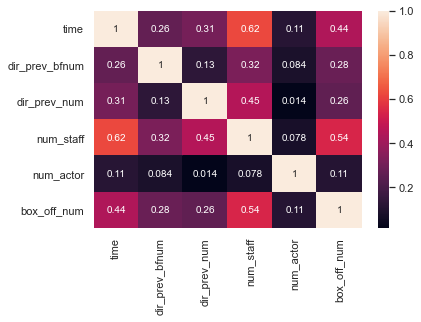

In [11]:
sns.heatmap(train.corr(), annot=True)

In [12]:
train.isna().sum() / 600 # 결측값이 있는지 여부

title             0.00
distributor       0.00
genre             0.00
release_time      0.00
time              0.00
screening_rat     0.00
director          0.00
dir_prev_bfnum    0.55
dir_prev_num      0.00
num_staff         0.00
num_actor         0.00
box_off_num       0.00
dtype: float64

In [13]:
train[train['dir_prev_bfnum'].isna()]['dir_prev_num'].sum() # NaN값이 있는 dir_prev_bfnum 컬럼 보고 dir_prev_num의 값을 전부 더한다.

0

In [14]:
train['dir_prev_bfnum'].fillna(0, inplace=True)

In [15]:
train.tail()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
595,해무,(주)NEW,드라마,2014-08-13,111,청소년 관람불가,심성보,3833.0,1,510,7,1475091
596,파파로티,(주)쇼박스,드라마,2013-03-14,127,15세 관람가,윤종찬,496061.0,1,286,6,1716438
597,살인의 강,(주)마운틴픽쳐스,공포,2010-09-30,99,청소년 관람불가,김대현,0.0,0,123,4,2475
598,악의 연대기,CJ 엔터테인먼트,느와르,2015-05-14,102,15세 관람가,백운학,0.0,0,431,4,2192525
599,베를린,CJ 엔터테인먼트,액션,2013-01-30,120,15세 관람가,류승완,0.0,0,363,5,7166532


In [16]:
test.isna().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    136
dir_prev_num        0
num_staff           0
num_actor           0
dtype: int64

In [17]:
test['dir_prev_bfnum'].fillna(0, inplace=True)

In [18]:
test.tail()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
238,해에게서 소년에게,디씨드,드라마,2015-11-19,78,15세 관람가,안슬기,2590.0,1,4,4
239,울보 권투부,인디스토리,다큐멘터리,2015-10-29,86,12세 관람가,이일하,0.0,0,18,2
240,어떤살인,(주)컨텐츠온미디어,느와르,2015-10-28,107,청소년 관람불가,안용훈,0.0,0,224,4
241,말하지 못한 비밀,(주)씨타마운틴픽쳐스,드라마,2015-10-22,102,청소년 관람불가,송동윤,50699.0,1,68,7
242,조선안방 스캔들-칠거지악 2,(주) 케이알씨지,멜로/로맨스,2015-10-22,76,청소년 관람불가,이전,0.0,0,10,4


### 기본 모델을 통한 결과 예측

In [19]:
model = lgb.LGBMRegressor(random_state=1234, n_estimators=1000)

In [20]:
features = ['time', 'dir_prev_num', 'num_staff', 'num_actor']
target = ['box_off_num']

In [24]:
X_train, X_test, y_train = train[features], test[features], train[target]

In [25]:
model.fit(X_train, y_train)

LGBMRegressor(n_estimators=1000, random_state=1234)

In [26]:
singleGBM = submission.copy()

In [27]:
singleGBM.tail()

,title,box_off_num
238,해에게서 소년에게,0
239,울보 권투부,0
240,어떤살인,0
241,말하지 못한 비밀,0
242,조선안방 스캔들-칠거지악 2,0


In [28]:
singleGBM['box_off_num'] = model.predict(X_test)

In [29]:
singleGBM.tail()

,title,box_off_num
238,해에게서 소년에게,5.007844e+05
239,울보 권투부,1.013858e+06
240,어떤살인,1.682068e+06
241,말하지 못한 비밀,3.002163e+05
242,조선안방 스캔들-칠거지악 2,1.139003e+04


In [30]:
singleGBM.to_csv('sigleGBM.csv', index=False)

### 교차검증을 활용한 성능 향상

In [31]:
from sklearn.model_selection import KFold

In [32]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=1234)

In [33]:
model = lgb.LGBMRegressor(random_state=1234,n_estimators=1000)

models = []

for train_idx, val_idx in k_fold.split(X_train):
    x_t = X_train.iloc[train_idx]
    y_t = y_train.iloc[train_idx]
    x_val = X_train.iloc[val_idx]
    y_val = y_train.iloc[val_idx]
    
    models.append(model.fit(x_t, y_t, eval_set=(x_val, y_val), early_stopping_rounds=100, verbose = 100))

Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 2.31354e+12
Early stopping, best iteration is:
[10]	valid_0's l2: 1.85171e+12
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 1.63028e+12
Early stopping, best iteration is:
[56]	valid_0's l2: 1.58134e+12
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 3.26748e+12
Early stopping, best iteration is:
[12]	valid_0's l2: 2.76612e+12
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 3.20319e+12
Early stopping, best iteration is:
[19]	valid_0's l2: 2.88465e+12
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 1.96647e+12
Early stopping, best iteration is:
[44]	valid_0's l2: 1.73011e+12


In [34]:
preds = []

for model in models:
    preds.append(model.predict(X_test))
len(preds)

5

In [35]:
kFoldLightGBM = submission.copy()

In [36]:
kFoldLightGBM['box_off_num'] = np.mean(preds, axis=0)

In [37]:
kFoldLightGBM.tail()

,title,box_off_num
238,해에게서 소년에게,87562.629898
239,울보 권투부,266851.503191
240,어떤살인,629867.658864
241,말하지 못한 비밀,-37396.222580
242,조선안방 스캔들-칠거지악 2,21489.743623


In [38]:
kFoldLightGBM.to_csv('kFoldLightGBM.csv', index=False)

### feature값 변경 (장르 추가)

In [39]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
train['genre'] = le.fit_transform(train['genre'])

In [40]:
train.tail(3)

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
597,살인의 강,(주)마운틴픽쳐스,1,2010-09-30,99,청소년 관람불가,김대현,0.0,0,123,4,2475
598,악의 연대기,CJ 엔터테인먼트,2,2015-05-14,102,15세 관람가,백운학,0.0,0,431,4,2192525
599,베를린,CJ 엔터테인먼트,10,2013-01-30,120,15세 관람가,류승완,0.0,0,363,5,7166532


In [41]:
test['genre'] = le.transform(test['genre'])

In [42]:
test.tail(3)

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
240,어떤살인,(주)컨텐츠온미디어,2,2015-10-28,107,청소년 관람불가,안용훈,0.0,0,224,4
241,말하지 못한 비밀,(주)씨타마운틴픽쳐스,4,2015-10-22,102,청소년 관람불가,송동윤,50699.0,1,68,7
242,조선안방 스캔들-칠거지악 2,(주) 케이알씨지,5,2015-10-22,76,청소년 관람불가,이전,0.0,0,10,4


In [43]:
features = ['time', 'dir_prev_num', 'num_actor', 'dir_prev_bfnum', 'genre']

In [44]:
X_train, X_test, y_train = train[features], test[features], train[target]

In [45]:
model = lgb.LGBMRegressor(random_state=1234,n_estimators=1000)

models = []

for train_idx, val_idx in k_fold.split(X_train):
    x_t = X_train.iloc[train_idx]
    y_t = y_train.iloc[train_idx]
    x_val = X_train.iloc[val_idx]
    y_val = y_train.iloc[val_idx]
    
    models.append(model.fit(x_t, y_t, eval_set=(x_val, y_val), early_stopping_rounds=100, verbose = 100))

Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 2.4493e+12
Early stopping, best iteration is:
[10]	valid_0's l2: 1.97285e+12
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 1.99084e+12
Early stopping, best iteration is:
[51]	valid_0's l2: 1.91451e+12
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 2.60856e+12
[200]	valid_0's l2: 2.45917e+12
Early stopping, best iteration is:
[150]	valid_0's l2: 2.40025e+12
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 3.32595e+12
Early stopping, best iteration is:
[36]	valid_0's l2: 3.1039e+12
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 2.73463e+12
Early stopping, best iteration is:
[18]	valid_0's l2: 2.53226e+12


In [46]:
preds = []

for model in models:
    preds.append(model.predict(X_test))
len(preds)

5

In [47]:
featureLightGBM = submission.copy()

In [48]:
featureLightGBM['box_off_num'] = np.mean(preds, axis=0)

In [49]:
featureLightGBM.to_csv('featureLightGBM.csv', index=False)

### 그리드 서치

In [50]:
from sklearn.model_selection import GridSearchCV

In [51]:
params = {
    'learning_rate': [0.1, 0.01, 0.003],
    'min_child_samples': [20, 30]
}

gs = GridSearchCV(estimator=model,
                 param_grid=params,
                  scoring= 'neg_mean_squared_error',
                  cv=k_fold)

In [52]:
gs.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
             estimator=LGBMRegressor(n_estimators=1000, random_state=1234),
             param_grid={'learning_rate': [0.1, 0.01, 0.003],
                         'min_child_samples': [20, 30]},
             scoring='neg_mean_squared_error')

In [53]:
gs.best_params_

{'learning_rate': 0.003, 'min_child_samples': 30}

In [54]:
model = lgb.LGBMRegressor(random_state=1234,n_estimators=1000, learning_rate=0.003, min_child_samples=30)

models = []

for train_idx, val_idx in k_fold.split(X_train):
    x_t = X_train.iloc[train_idx]
    y_t = y_train.iloc[train_idx]
    x_val = X_train.iloc[val_idx]
    y_val = y_train.iloc[val_idx]
    
    models.append(model.fit(x_t, y_t, eval_set=(x_val, y_val), early_stopping_rounds=100, verbose = 100))

Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 2.24586e+12
[200]	valid_0's l2: 2.06866e+12
[300]	valid_0's l2: 2.01984e+12
[400]	valid_0's l2: 1.97391e+12
[500]	valid_0's l2: 1.94183e+12
[600]	valid_0's l2: 1.92851e+12
[700]	valid_0's l2: 1.9227e+12
[800]	valid_0's l2: 1.92202e+12
Early stopping, best iteration is:
[781]	valid_0's l2: 1.92091e+12
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 2.44967e+12
[200]	valid_0's l2: 2.20074e+12
[300]	valid_0's l2: 2.04701e+12
[400]	valid_0's l2: 1.95604e+12
[500]	valid_0's l2: 1.90441e+12
[600]	valid_0's l2: 1.87509e+12
[700]	valid_0's l2: 1.84389e+12
[800]	valid_0's l2: 1.82532e+12
[900]	valid_0's l2: 1.82508e+12
Early stopping, best iteration is:
[836]	valid_0's l2: 1.82447e+12
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 2.99776e+12
[200]	valid_0's l2: 2.78437e+12
[300]	valid_0's l2: 2.67222e+12
[400]	valid_0's l2: 2.61582e+12
[500]	val

In [55]:
preds = []

for model in models:
    preds.append(model.predict(X_test))
len(preds)

5

In [56]:
gridSearchGBM = submission.copy()
gridSearchGBM['box_off_num'] = np.mean(preds, axis=0)
gridSearchGBM.to_csv('gridSearchGBM.csv', index=False)